<a href="https://colab.research.google.com/github/Hirakhan15/PCOs/blob/main/pcos1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()  # Select your PCOS_dataset.zip (or similar name)

Saving PCOS dataset.zip to PCOS dataset (1).zip


In [3]:
!unzip "PCOS dataset.zip" -d /content/  # Replace with your exact ZIP filename if different
# Verify structure
!ls /content/
!ls /content/PCOS\ dataset/train  # Should show 'infected' 'noninfected' (adjust path if needed)

Archive:  PCOS dataset.zip
  inflating: /content/PCOS_data_without_infertility.xlsx  
  inflating: /content/PCOS_infertility.csv  
   creating: /content/PCOS dataset/
   creating: /content/PCOS dataset/test/
   creating: /content/PCOS dataset/test/infected/
  inflating: /content/PCOS dataset/test/infected/img1.jpg  
  inflating: /content/PCOS dataset/test/infected/img10.jpg  
  inflating: /content/PCOS dataset/test/infected/img2.jpg  
  inflating: /content/PCOS dataset/test/infected/img3.jpg  
  inflating: /content/PCOS dataset/test/infected/img4.jpg  
  inflating: /content/PCOS dataset/test/infected/img5.jpg  
  inflating: /content/PCOS dataset/test/infected/img6.jpg  
  inflating: /content/PCOS dataset/test/infected/img7.jpg  
  inflating: /content/PCOS dataset/test/infected/img8.jpg  
  inflating: /content/PCOS dataset/test/infected/img_0_1023.jpg  
  inflating: /content/PCOS dataset/test/infected/img_0_1033.jpg  
  inflating: /content/PCOS dataset/test/infected/img_0_1071.jpg  
  i

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

# Adjust this path based on unzip output (e.g., '/content/' if direct, or with folder name)
data_dir = '/content/PCOS dataset'  # Common after unzip; check with !ls

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
               for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(f"Classes: {class_names} (0: infected/PCOS, 1: noninfected/normal)")
print(f"Train size: {dataset_sizes['train']}, Test size: {dataset_sizes['test']}")

# Load pre-trained MobileNetV3-Large
model = models.mobilenet_v3_large(pretrained=True)
num_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_features, 2)  # 2 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 25
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), '/content/best_pcos_mobilenetv3.pth')

print(f'Best test accuracy: {best_acc:.4f}')
# Download model: Files tab > right-click > Download

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classes: ['infected', 'notinfected'] (0: infected/PCOS, 1: noninfected/normal)
Train size: 1562, Test size: 1562
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 186MB/s]


Using device: cuda
Epoch 1/25
Train Loss: 0.0802 Acc: 0.9706
Test Loss: 0.0000 Acc: 1.0000
Epoch 2/25
Train Loss: 0.0281 Acc: 0.9878
Test Loss: 0.0000 Acc: 1.0000
Epoch 3/25
Train Loss: 0.0277 Acc: 0.9898
Test Loss: 0.0390 Acc: 0.9962
Epoch 4/25
Train Loss: 0.0256 Acc: 0.9898
Test Loss: 0.0000 Acc: 1.0000
Epoch 5/25
Train Loss: 0.0528 Acc: 0.9923
Test Loss: 0.0314 Acc: 0.9930
Epoch 6/25
Train Loss: 0.0253 Acc: 0.9923
Test Loss: 0.0253 Acc: 0.9942
Epoch 7/25
Train Loss: 0.0204 Acc: 0.9930
Test Loss: 0.0220 Acc: 0.9942
Epoch 8/25
Train Loss: 0.0169 Acc: 0.9942
Test Loss: 0.0001 Acc: 1.0000
Epoch 9/25
Train Loss: 0.0090 Acc: 0.9968
Test Loss: 0.0000 Acc: 1.0000
Epoch 10/25
Train Loss: 0.0065 Acc: 0.9968
Test Loss: 0.0000 Acc: 1.0000
Epoch 11/25
Train Loss: 0.0067 Acc: 0.9962
Test Loss: 0.0000 Acc: 1.0000
Epoch 12/25
Train Loss: 0.0064 Acc: 0.9974
Test Loss: 0.0000 Acc: 1.0000
Epoch 13/25
Train Loss: 0.0019 Acc: 0.9994
Test Loss: 0.0000 Acc: 1.0000
Epoch 14/25
Train Loss: 0.0048 Acc: 0.998

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# Put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification Report (Precision, Recall, F1)
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)


Confusion Matrix:
 [[781   0]
 [  0 781]]
Classification Report:
               precision    recall  f1-score   support

    infected       1.00      1.00      1.00       781
 notinfected       1.00      1.00      1.00       781

    accuracy                           1.00      1562
   macro avg       1.00      1.00      1.00      1562
weighted avg       1.00      1.00      1.00      1562



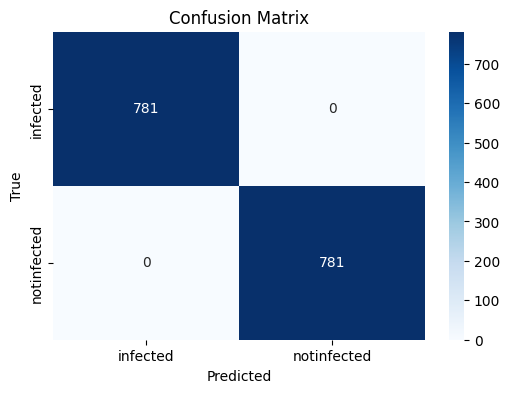

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
